## Imports and Preliminaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
import torch
from torch import nn
from torch.nn.functional import interpolate
from torch.utils.data import DataLoader

## Part 1: Data Geneneration

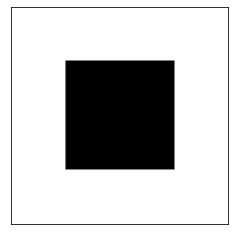

In [2]:
#Lets start by just have a data object that is a simple square
H=W=256
canvas = np.zeros([256,256])
canvas[64:256-64,64:256-64] = 1.0
plt.imshow(canvas,cmap='gray_r')
plt.xticks([]);plt.yticks([]);

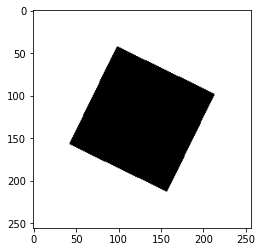

In [8]:
#rotation for fun https://stackoverflow.com/a/18683594
def rotate_img(img,deg=None):
    if deg == None:
        deg = np.random.randint(0,360)
    return (ndimage.rotate(img, deg, reshape=False))>.5
plt.imshow(rotate_img(canvas),cmap='gray_r')
rotated = rotate_img(canvas)

In [9]:
#Some plotting code
def add_axis_grid(ax,H,W,R):
    #https://stackoverflow.com/questions/38973868/adjusting-gridlines-and-ticks-in-matplotlib-imshow
    # Major ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Labels for major ticks
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Minor ticks
    ax.set_xticks(np.arange(-.5, W, R), minor=True)
    ax.set_yticks(np.arange(-.5, H, R), minor=True)
    
    # Gridlines based on minor ticks
    ax.grid(which='minor', color='b', linestyle='-', linewidth=1)

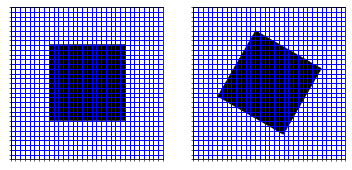

In [10]:
R = 8
plt.subplot(121)
plt.imshow(canvas,cmap='gray_r')
add_axis_grid(plt.gca(),H,W,R)
plt.subplot(122)
plt.imshow(rotated,cmap='gray_r')
add_axis_grid(plt.gca(),H,W,R)

### Getting image patches into point cloud format

In [11]:
#Some code for getting nonoverlapping patches
psz=16
img_patches = nn.Unfold(psz, psz)(torch.tensor(rotated>.5).to(torch.float64).view(1,1,H,W)).view(-1, int(H/psz), int(W/psz))

In [12]:
psz=16
img_patches = nn.Unfold(psz, psz)(torch.tensor(rotated>.5).to(torch.float64).view(1,1,H,W)).view(-1, int(H/psz), int(W/psz))
R = 8
xs = torch.arange(R).to(torch.float64)
ys = torch.arange(R).to(torch.float64)
grid_x, grid_y = torch.meshgrid(xs, ys, indexing='ij')
grid_x = grid_x.flatten().view(1,1,-1).expand(img_patches.shape[0],-1,-1)
grid_y = grid_y.flatten().view(1,1,-1).expand(img_patches.shape[0],-1,-1)

In [13]:
interp = interpolate(img_patches.unsqueeze(0), size=[8,8]).view(img_patches.shape[0],-1,R**2)

In [14]:
interp = interpolate(img_patches.unsqueeze(0), size=[8,8]).view(img_patches.shape[0],-1,R**2)
point_cloud = torch.cat([grid_x,grid_y,interp],dim=1)

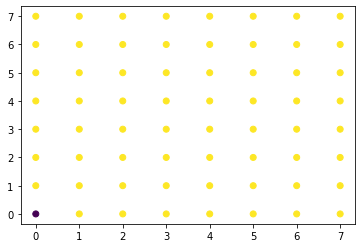

In [15]:
plt.scatter(point_cloud[85,0,:],point_cloud[85,1,:],c=point_cloud[85,2,:])

### Using the "Animals" Dataset

In [16]:
# https://sites.google.com/site/xiangbai/animaldataset
import os
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

In [17]:
H=W=256
transform_list = transforms.Compose([
    transforms.Resize([int(H*5/8),int(W*5/8)]),
    transforms.Pad([int(H*3/16),int(W*3/16)]),
    transforms.Grayscale(),
    transforms.ToTensor()])
dataset=datasets.ImageFolder(root="./non_rigid_shape_A/",transform=transform_list)


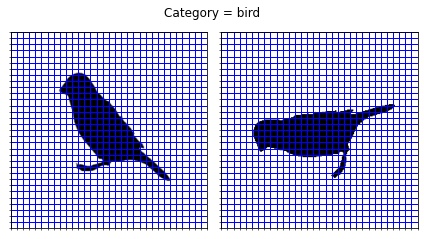

In [18]:
test_img = dataset[0][0].permute(1,2,0)
plt.subplot(121)
plt.imshow(test_img,cmap='gray_r')
add_axis_grid(plt.gca(),H,W,R)
plt.subplot(122)
plt.imshow(rotate_img(test_img),cmap='gray_r')
add_axis_grid(plt.gca(),H,W,R)
plt.tight_layout(rect=[0, 0, 1, 1.1])
plt.suptitle(f'Category = {dataset.classes[dataset[0][1]]}');


In [19]:
from torch.utils.data import DataLoader
train_set, test_set = torch.utils.data.random_split(dataset, [int(len(dataset)*4/5), int(len(dataset)*1/5)])
train_dataloader = DataLoader(train_set, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=10, shuffle=True)

In [81]:
#function here : make pointclouds ->
def make_pointclouds(imgs,psz=16,R=8):
    '''
    Takes in tensors of size [bsz,1,H,W]
    Returns output of size [bsz,H/psz*W/psz (Number of patches),R**2,3]
    '''
    bsz,_,H,W = imgs.shape
    img_patches = nn.Unfold(psz, psz)((imgs>.5).to(torch.float64).view(bsz,1,H,W)).view(bsz,-1, int(H/psz), int(W/psz))
    xs = torch.arange(R).to(torch.float64)
    ys = torch.arange(R).to(torch.float64)
    grid_x, grid_y = torch.meshgrid(xs, ys, indexing='ij')
    # Repeat the coordinate information for each batch and patch
    grid_x = grid_x.flatten().view(1,1,-1).expand(img_patches.shape[0],img_patches.shape[1],-1).unsqueeze(-1)
    grid_y = grid_y.flatten().view(1,1,-1).expand(img_patches.shape[0],img_patches.shape[1],-1).unsqueeze(-1)
    interp = interpolate(img_patches, size=[8,8]).view(img_patches.shape[0],-1,R**2).unsqueeze(-1)
    point_cloud = torch.cat([grid_x,grid_y,interp],dim=-1).to(torch.float)
    return point_cloud

In [82]:
for batch in train_dataloader:
    imgs,labels = batch
    pcs= make_pointclouds(imgs)

In [23]:
pcs.shape

torch.Size([10, 256, 64, 3])

## Part 2: Modelling

In [60]:
# Create an embedder with vector neurons
# Where I am at right now: I have created a torch dataset that has all of the images that I want in there
# I have also created a couple of lines of code that will take an image and turn it into a point cloud
# I need to see if I can make this work for a group of images in a batch and how to batch images for a dataloader
# After this I work on modeling, which is basically seeing if I can get an implementation of vnn working before anything else

from models.vn_layers import VNLinearLeakyReLU,VNLinear
from models.vn_pointnet import PointNetEncoder

In [126]:
# Implement vnn code 
# Couple of vnn layers with a linear dimension... after this linear dimension apply traditional apporaches like mlp for prediction
# Train end to end model on classification task 
# Basic batch classification on the outputs of the model

class VN_encoder(nn.Module):
    def __init__(self):
        super(VN_encoder, self).__init__()
        self.layer1 = VNLinearLeakyReLU(64,32,dim=5)
        self.layer2 = VNLinearLeakyReLU(32,16,dim=4)
        self.layer3 = VNLinear(16,8)
    def forward(self,x):
        x = self.layer1(x)
        return self.layer3(self.layer2(x)).permute(0,3,1,2)

class MLP_encoder(nn.Module):
    def __init__(self):
        super(MLP_encoder, self).__init__()
        self.layer1 = nn.Sequential(*[nn.Linear(64*3,32*3),nn.LeakyReLU()])
        self.layer2 = nn.Sequential(*[nn.Linear(32*3,16*3),nn.LeakyReLU()])
        self.layer3 = nn.Linear(16*3,8*3)
        
    def forward(self,x):
        x = self.layer1(x)
        return self.layer3(self.layer2(x))
    
class MLP_decoder(nn.Module):
    def __init__(self,N=256):
        super(MLP_decoder, self).__init__()
        in_dim = 24 #8*3
        self.layer1 = nn.Sequential(*[nn.Linear(N*8*3,N*8),nn.LeakyReLU()])
        self.layer2 = nn.Sequential(*[nn.Linear(N*8,N),nn.LeakyReLU()])
        self.layer3 = nn.Linear(N,10)
    
    def forward(self,x):
        x = self.layer1(x)
        return self.layer3(self.layer2(x))


In [127]:
test = VN_encoder()
test2 = MLP_encoder()
test3 = MLP_decoder()

In [128]:
test2(pcs.view(pcs.shape[0],pcs.shape[1],-1)).shape

torch.Size([10, 256, 24])

In [ ]:
enc_model = VN_encoder()
dec_model = MLP_decoder()
optim = optim = torch.optim.Adam(list(enc_model.parameters()) + list(dec_model.parameters()), lr=1e-4, betas=(0.9, 0.96), weight_decay=4.5e-2)
lossfn = nn.CrossEntropyLoss()

for epoch in range(10):
    epoch_loss = 0
    acc_list = []
    for i,batch in enumerate(train_dataloader):
        imgs,labels = batch
        pcs= make_pointclouds(imgs)
        encoding = enc_model(pcs.permute(0,2,3,1))
        pred_labels = dec_model(encoding.reshape(encoding.shape[0],-1))
        loss = lossfn(pred_labels,labels.to(torch.long))
        epoch_loss += loss.detach().item()
        loss.backward()
        optim.step()
        optim.zero_grad()
        acc_list.append(torch.mean(pred_labels.argmax(1) == labels))
    print(f'Epoch: {epoch}, loss = {epoch_loss}, accuracy = {torch.mean(acc_list)}')
    

Epoch: 0, loss = 184.94331526756287
Epoch: 1, loss = 184.34732389450073
Epoch: 2, loss = 184.24916577339172
Epoch: 3, loss = 184.2281951904297
Epoch: 4, loss = 184.23351860046387
Epoch: 5, loss = 184.2285590171814
Epoch: 6, loss = 184.2271270751953
Epoch: 7, loss = 184.22475266456604
Epoch: 8, loss = 184.22450137138367


torch.int64

In [110]:
t = test(pcs.permute(0,2,3,1))
B,N = t.shape[:2]
test3(t.reshape(B,-1))

tensor([[-0.0457],
        [-0.0484],
        [-0.0450],
        [-0.0407],
        [-0.0497],
        [-0.0466],
        [-0.0434],
        [-0.0435],
        [-0.0448],
        [-0.0492]], grad_fn=<AddmmBackward0>)

In [102]:
t.shape

torch.Size([10, 256, 8, 3])

In [104]:
t.reshape(10,256,24).shape

torch.Size([10, 256, 24])

In [262]:
pcs.shape

torch.Size([10, 256, 64, 3])

In [271]:
pcs.transpose(1, -1).shape

torch.Size([10, 3, 64, 256])